# Import Libraries and Set Working Directory

In [90]:
from google.colab import drive
drive.mount('/content/drive')
import glob
import pandas as pd
import numpy as np
import datetime
from sklearn.linear_model import LogisticRegression
!pip install wget
import wget
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import copy
from sklearn.metrics import confusion_matrix
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as pyplot
from sklearn import svm
from sklearn.metrics import brier_score_loss
from sklearn import svm
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
YOUR_DIRECTORY = '/content/drive/My Drive/Colab Notebooks/Project_5/'

# Get Data
<b> Get Data </b> - Once you run this and have the data, do not need to run again.

In [0]:
# Pulling KSTC Observations from NCDC for 2000-2020
years = np.arange(2000, 2021)
months = np.arange(1, 13)
for y in years:
    print(y)
    for m in months:
        try:
            wget.download('ftp://ftp.ncdc.noaa.gov/pub/data/asos-fivemin/6401-' + str(y) + '/64010KSTC' + str(y) + str(m).zfill(2) + '.dat', out = YOUR_DIRECTORY + 'project5_data/')
        except:
            print("All current files grabbed")
            break

<b> Reformat files to be readable as CSVs </b> - once you have this, do not need to run again.

In [0]:
import glob
import pandas as pd
import numpy as np
import datetime

# Processing KSTC Observational data from 2000-2020
for yr in range(2000, 2020):
  print('Year = ', yr)
  files = sorted(glob.glob(YOUR_DIRECTORY + 'project5_data/64010KSTC' + str(yr) + '*.dat'))

  for ifile in range(0, len(files)):
      print(ifile)
      f = open(files[ifile], 'rb')
      df = pd.DataFrame([str(f.readline()).replace('\\n\'', '').replace('b\'', '').strip().split(' ')])
      for line in f:
          data = pd.DataFrame([str(f.readline()).replace('\\n\'', '').replace('b\'', '').strip().split(' ')])
          df = pd.concat([df, data], ignore_index = True)  
      # df = pd.DataFrame([line.strip().split(' ') for line in open(files[ifile], 'r')])
      del df[3]
      n_cols = len(df.columns)

      ## Setting initial set of column names, and then writing them to an output file, with remaining number of columns set to X
      columns = ['StnNo', 'ContainsDate', 'Time', "Interval", 'Sttn', 'UTC', 'Type', 'Wind', "Weath/Obstr", 'SkyCond', 'Temp',
                    'n_days', 'MSLP', 'RelHum', ' ', 'WndDir/Spd', 'WindMagnetic', 'RMK', 'AO2']
      out_name = files[ifile].replace(YOUR_DIRECTORY + 'project5_data/', YOUR_DIRECTORY + 'project5_data/reviewed')
      out = open(out_name, 'w')
      out.write('date'+','+'timeofday'+','+'Wind'+','+'Wind_Direction'+','+'Wind_Speed'+','+'Gusts'+','+'Variable_Winds'+','+'Temperature'+','+ 
                        'Dewpoint'+','+'rhum'+','+'hourly'+','+'sixhourly'+','+'dayprecip'+','+'solid'+','+'liquid'+'\n')
      # new_df = pd.DataFrame(columns=new_df_columns)
      cols_already = len(columns)
      cols_new = []
      cols_new = [np.append(cols_new, 'X') for i in range(n_cols-cols_already)]
      columns = np.append(columns, cols_new)
      df.columns = columns

      for i in range(0, np.shape(df)[0]): #np.shape(df)[0]
          try:
            ## Processing datetime code
            day = df['ContainsDate'][i][-8:] 
            time = df['Time'][i]
            date = datetime.datetime.strptime(day + ' ' + time, '%m/%d/%y %H:%M:%S')
            (h, m, s) = time.split(':')
            timeofday = float(int(h) * 3600 + int(m) * 60 + int(s)) / (3600*24)
            # print(date)
            # print(timeofday)

            ## Processing wind speed and direction METAR code
            Gusts = 0
            Wind = 0
            Variable_Winds = 0
            try:
              if "KT" in df['Wind'][i]:
                  Wind = 1
                  if df['Wind'][i][0:3] == 'VRB':
                      Variable_Winds = 1
                  else:
                      Variable_Winds = 0
                      Wind_Direction = int(df['Wind'][i][0:3]) # in tens of degrees from true north
                  Wind_Speed = int(df['Wind'][i][3:5]) # in whole knots (two digits)
                  if df['Wind'][i][5] == 'G':
                      Gusts = 1
                      Gust_Speed = int(df['Wind'][i][6:8]) # speed in whole knots (two digits)
              else:
                  Wind = 0
            except:
              Wind = 0
              Variable_Winds = 0
              Wind_Direction = np.nan
              Gusts=0
              Gust_Speed=0

            ## Processing temperature, relative humidity, and precipitation METAR code
            Temp = 0
            try:
              if "/" in df['Temp'][i]:
                  Temp = 1
                  Temperature = df['Temp'][i].split('/')[0]
                  if 'M' in Temperature:
                    Temperature = int(Temperature[1:3])
                  else:
                    Temperature = int(Temperature)
                  Dewpoint = df['Temp'][i].split('/')[1]
                  if 'M' in Dewpoint:
                    Dewpoint = int(Dewpoint[1:3])
                  else:
                    Dewpoint = int(Dewpoint) 
              else:
                  Temp = 0  
              try:
                rhum = int(df['RelHum'][i])
              except:
                rhum = np.nan
              if (rhum > 100):
                rhum = np.nan
            except:
              Temp = 0
              Temperature = np.nan
              Dewpoint = np.nan
              rhum = np.nan

            ## Processing precipitation METAR code
            for n in range(cols_already, n_cols): #n_cols
              # for j in range(len(df.iloc[:,n])):
                element = df.iloc[i,n]
                try:
                  if element[0] == 'P' or element[0] == '6' or element[0] == '7':
                    if element[1] == '0':
                      if element[0] == 'P':
                        hourly = float(element[1:]) / 100.
                      elif element[0]=='6':
                        sixhourly = float(element[1:]) / 100.
                      elif element[0] == '7':
                        dayprecip = float(element[1:]) / 100.
                  else:
                    hourly = np.nan
                    sixhourly = np.nan
                    dayprecip = np.nan
                except:
                    hourly = np.nan
                    sixhourly = np.nan
                    dayprecip = np.nan

            ## Setting liquid and frozen precipitation flags
            frozen_flags = ['SN', 'SG', 'IC', 'PL', 'GR', 'GS']
            liquid_flags = ['FZ', 'RA']
            try:
                if np.logical_or(any(flags in df['Weath/Obstr'][i] for flags in frozen_flags), any(flags in df['Temp'][i] for flags in frozen_flags)):
                  solid = 1
                elif np.logical_or(any(flags in df['Weath/Obstr'][i] for flags in liquid_flags), any(flags in df['Temp'][i] for flags in liquid_flags)):
                  liquid = 1
                else:
                  solid = 0
                  liquid = 0
            except:
                  solid = np.nan
                  liquid = np.nan

            ## Writing processed data to output file
            # print('Wind, Wind_Direction, Wind_Speed, Gusts, Variable_Winds, Temp, Temperature, Dewpoint, rhum, hourly, sixhourly, daily:') 
            # print(str(date)+','+str(timeofday)+','+str(Wind)+','+str(Wind_Direction)+','+str(Wind_Speed)+','+str(Gusts)+','+str(Variable_Winds)
            # +','+str(Temperature)+','+str(Dewpoint)+','+str(rhum)+','+str(hourly)+','+str(sixhourly)+','+str(dayprecip)+','+str(solid)+','+str(liquid)+'\n')
            out.write(str(date) + ',' + str(timeofday) + ',' + str(Wind) + ',' + str(Wind_Direction) + ',' + str(Wind_Speed) + ',' + str(Gusts) + ',' + str(Variable_Winds) + 
            ',' + str(Temperature) + ',' + str(Dewpoint) + ',' + str(rhum) + ',' + str(hourly) + ',' + str(sixhourly) + ',' + str(dayprecip) + ',' + str(solid) + 
            ',' + str(liquid) + '\n')
            
          except:
            continue
      out.close()

# Read in and adjust data

In [126]:
# Read in the file
data = pd.read_csv(YOUR_DIRECTORY + 'data.csv')
data['date'] = pd.to_datetime(data['date']).apply(lambda x: x.strftime('%j')) # Change date column to datetime

# Drop Columns
data.drop(columns = ['Wind', 'sixhourly', 'dayprecip', 'Gusts', 'hourly', 'solid', 'liquid', 'Variable_Winds'], inplace = True)

# Replace negative RH values with NaNs
data.loc[(data['rhum'] < 0)] = np.nan

# Drop NaNs
data = data.filter(['date','timeofday', 'Wind_direction', 'Wind_speed', 'Temperature', 'Dewpoint', 'rhum', 'prcp_type']).dropna()
data.describe()

,timeofday,Temperature,Dewpoint,rhum,prcp_type
count,6231.000000,6231.000000,6231.000000,6231.00000,6231.000000
mean,0.565615,11.670358,8.717541,80.65784,0.402664
std,0.208864,6.335851,5.753035,11.36367,0.490474
min,0.003831,1.000000,0.000000,18.00000,0.000000
25%,0.382303,7.000000,4.000000,74.00000,0.000000
50%,0.548970,12.000000,8.000000,81.00000,0.000000
75%,0.746887,16.000000,13.000000,89.00000,1.000000
max,0.996887,36.000000,25.000000,100.00000,1.000000


## Model Features

In [0]:
labels = data['prcp_type'].to_numpy()
feats = data.drop(columns = ['prcp_type']).to_numpy()

## Make training and test sets

In [0]:
train_features, test_features, train_labels, test_labels = train_test_split(feats, labels, test_size = 0.3, random_state = 42)

# 1. Logistic Regression

## Train Model

In [129]:
clf = LogisticRegression(max_iter=10e10, random_state=42)
clf.fit(train_features, train_labels)

training_probability = clf.predict_proba(train_features)
testing_probability = clf.predict_proba(test_features)

print('Training Score: ' + str(clf.score(train_features, train_labels)))
print('Testing Score: ' + str(clf.score(test_features, test_labels)))

print('Training Brier Score: ' + str(brier_score_loss(train_labels, clf.predict(train_features))))
print('Testing Brier Score: ' + str(brier_score_loss(test_labels, clf.predict(test_features))))

Training Score: 0.7984407246044485
Testing Score: 0.7818181818181819
Training Brier Score: 0.2015592753955515
Testing Brier Score: 0.21818181818181817


## Confusion Matrix

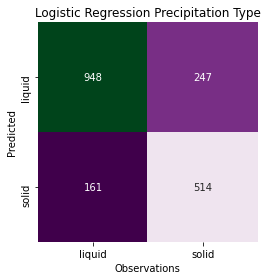

In [130]:
# Create Matrix
matrix = confusion_matrix(test_labels, clf.predict(test_features))

# Plot matrix
labels = ['liquid', 'solid']
sns.heatmap(matrix.T, square = True, annot = True, fmt = 'd', cbar = False, xticklabels = labels, yticklabels = labels, cmap = 'PRGn')
pyplot.title('Logistic Regression Precipitation Type')
pyplot.xlabel('Observations')
pyplot.ylabel('Predicted')
pyplot.tight_layout()
pyplot.savefig(YOUR_DIRECTORY + 'logregression_confmatrix.png', dpi=300)

# 2. Random Forest Regression

## Train Model

In [137]:
#rfc = RandomForestClassifier(n_estimators = 1600, random_state = 42, max_depth = 80, max_features = 'auto', min_samples_leaf = 1, min_samples_split = 3, bootstrap = True)
rfc = RandomForestClassifier(n_estimators = 100, random_state = 42)
rfc.fit(train_features, train_labels)

training_probability = rfc.predict_proba(train_features)
testing_probability = rfc.predict_proba(test_features)

print('Training Score: ' + str(rfc.score(train_features, train_labels)))
print('Testing Score: ' + str(rfc.score(test_features, test_labels)))

print('Training Brier Score: ' + str(brier_score_loss(train_labels, rfc.predict(train_features))))
print('Testing Brier Score: ' + str(brier_score_loss(test_labels, rfc.predict(test_features))))

Training Score: 1.0
Testing Score: 0.9871657754010695
Training Brier Score: 0.0
Testing Brier Score: 0.012834224598930482


## Create Matrix

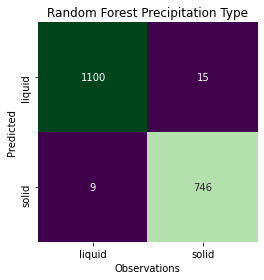

In [138]:
# Create Matrix
matrix = confusion_matrix(test_labels, rfc.predict(test_features))

# Plot matrix
labels = ['liquid', 'solid']
sns.heatmap(matrix.T, square = True, annot = True, fmt = 'd', cbar = False, xticklabels = labels, yticklabels = labels, cmap = 'PRGn')
pyplot.title('Random Forest Precipitation Type')
pyplot.xlabel('Observations')
pyplot.ylabel('Predicted')
pyplot.tight_layout()
pyplot.savefig(YOUR_DIRECTORY + 'randforestregress_confmatrix.png', dpi = 300)

## 3. SVM

## Train Model

In [139]:
svmc = svm.SVC()
svmc.fit(train_features, train_labels)

print('Training Score: ' + str(svmc.score(train_features, train_labels)))
print('Testing Score: ' + str(svmc.score(test_features, test_labels)))

print('Training Brier Score: ' + str(brier_score_loss(train_labels, svmc.predict(train_features))))
print('Testing Brier Score: ' + str(brier_score_loss(test_labels, svmc.predict(test_features))))

Training Score: 0.8993350149048384
Testing Score: 0.895187165775401
Training Brier Score: 0.10066498509516165
Testing Brier Score: 0.10481283422459893


## Confusion Matrix

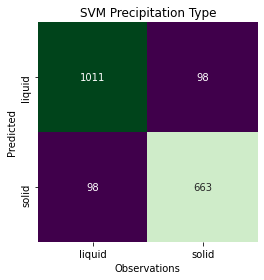

In [140]:
# Create Matrix
matrix = confusion_matrix(test_labels, svmc.predict(test_features))

# Plot matrix
labels = ['liquid', 'solid']
sns.heatmap(matrix.T, square = True, annot = True, fmt = 'd', cbar = False, xticklabels = labels, yticklabels = labels, cmap = 'PRGn')
pyplot.title('SVM Precipitation Type')
pyplot.xlabel('Observations')
pyplot.ylabel('Predicted')
pyplot.tight_layout()
pyplot.savefig(YOUR_DIRECTORY + 'svm_confmatrix.png', dpi = 300)